Intento de EDA visualizando correlación local entre pixeles cercanos. Cargamos librerías útiles y utilidades que permiten analizar correlación de pixeles cercanos.

In [2]:
import numpy as np
import pandas as pd
from utilities import *

Cargamos matrices de velocidad, extents, polígonos y máscaras. Para más información ver notebook `0_interferometria_triangulacion.ipynb`

In [33]:
c1 = np.load("../data/c_1/vel.npy")
c2 = np.load("../data/c_2/vel.npy")
c3 = np.load("../data/c_3/vel.npy")

extent1 = pd.read_csv("https://raw.githubusercontent.com/alcazar90/rock-glacier-detection/main/data/c_1/extent.tsv", 
                      sep="\t", header=None).to_numpy()
extent2 = pd.read_csv("https://raw.githubusercontent.com/alcazar90/rock-glacier-detection/main/data/c_2/extent.tsv", 
                      sep="\t", header=None).to_numpy()
extent3 = pd.read_csv("https://raw.githubusercontent.com/alcazar90/rock-glacier-detection/main/data/c_3/extent.tsv", 
                      sep="\t", header=None).to_numpy()

glaciares = {f"glaciar_{n}": pd.read_csv(f"https://raw.githubusercontent.com/alcazar90/rock-glacier-detection/main/data/\
glaciares/glaciar_{n}_strict.tsv", sep="\t", header=None).to_numpy()[:-1, [1,0]] for n in range(1, 7)}

glaciares_list = list(glaciares.values())

con_glaciares = {f"glaciar_area_{n}": pd.read_csv(f"https://raw.githubusercontent.com/alcazar90/rock-glacier-detection/main/\
data/glaciares/glaciar_area_{n}.tsv", sep="\t", header=None).to_numpy()[:-1, [1,0]] for n in range(1, 5)}
con_glaciares["argentina"] = pd.read_csv("https://raw.githubusercontent.com/alcazar90/rock-glacier-detection/main/\
data/glaciares/argentina.tsv", sep="\t", header=None).to_numpy()[:-1, [1,0]]

con_glaciares_list = list(con_glaciares.values())

en_glaciares_c1 = np.load("../data/masks/en_glaciar_c1.npy")
en_glaciares_c3 = np.load("../data/masks/en_glaciar_c3.npy")
sin_glaciares_c1 = np.load("../data/masks/sin_glaciar_c1.npy")
sin_glaciares_c3 = np.load("../data/masks/sin_glaciar_c3.npy")

Creamos los mappers para visualizar

In [28]:
mapper1 = mapper(extent1, c1.shape)
mapper3 = mapper(extent3, c3.shape)

Creamos los colormaps

In [29]:
colors = np.column_stack((np.ones((256, 3)), np.linspace(0, 1, 256)))
alpha = LinearSegmentedColormap.from_list(name = "alpha", colors=colors)
glow = LinearSegmentedColormap.from_list(name = "glow", colors=colors*np.array([0.97, 0.58, 0.2, 1]))
danger = LinearSegmentedColormap.from_list(name = "danger", colors=colors*np.array([0.85, 0.2, 0.45, 1]))
sky = LinearSegmentedColormap.from_list(name = "sky", colors=colors*np.array([0.25, 0.45, 0.95, 1]))

colors2 = np.array([[0, .95, 1,1], [0,0,0,1], [.75,.9,0,1]])
fluor = LinearSegmentedColormap.from_list(name = "fluor", colors=colors2)

# Rugosidad
Evaluamos la diferencia de cada pixel con los cercanos utilizando la formula sum(P - PQ) donde P es el pixel central y Q los pixeles cercanos

In [30]:
vel_subc = substract_correlation(c3, (5, 5))

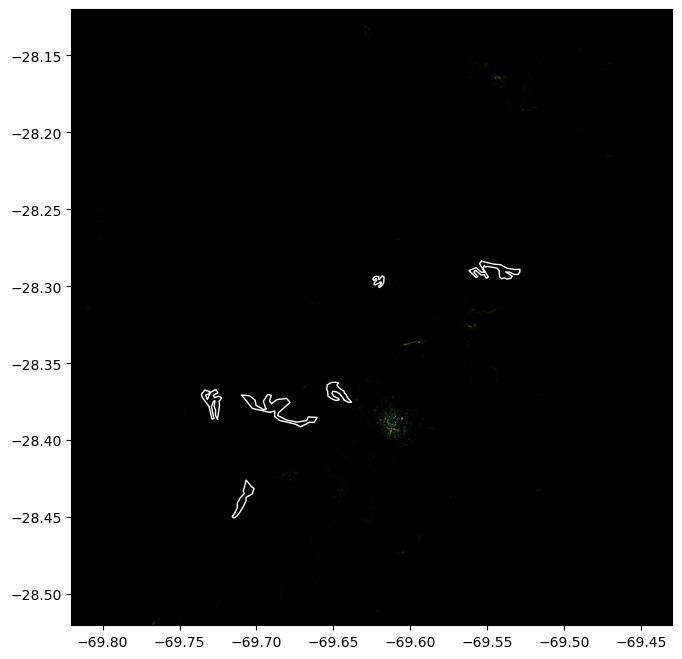

In [31]:
mapper3.draw(vel_subc, cmaps=fluor, center_scale=True, glaciares = glaciares_list, linewidth=1)

# Distribución de velocidades

Se realizan histogramas con las velocidades de los pixeles de la clase glaciar y no glaciar.

In [34]:
X = np.linspace(-.025, .025, 1000)
vel_notgla = density(X, c3.flatten()[sin_glaciares_c3.flatten()], sigma_scale=.05)
vel_gla    = density(X, c3.flatten()[ en_glaciares_c3.flatten()], sigma_scale=.1)

Graficamos

Text(0, 0.5, 'Densidad relativa')

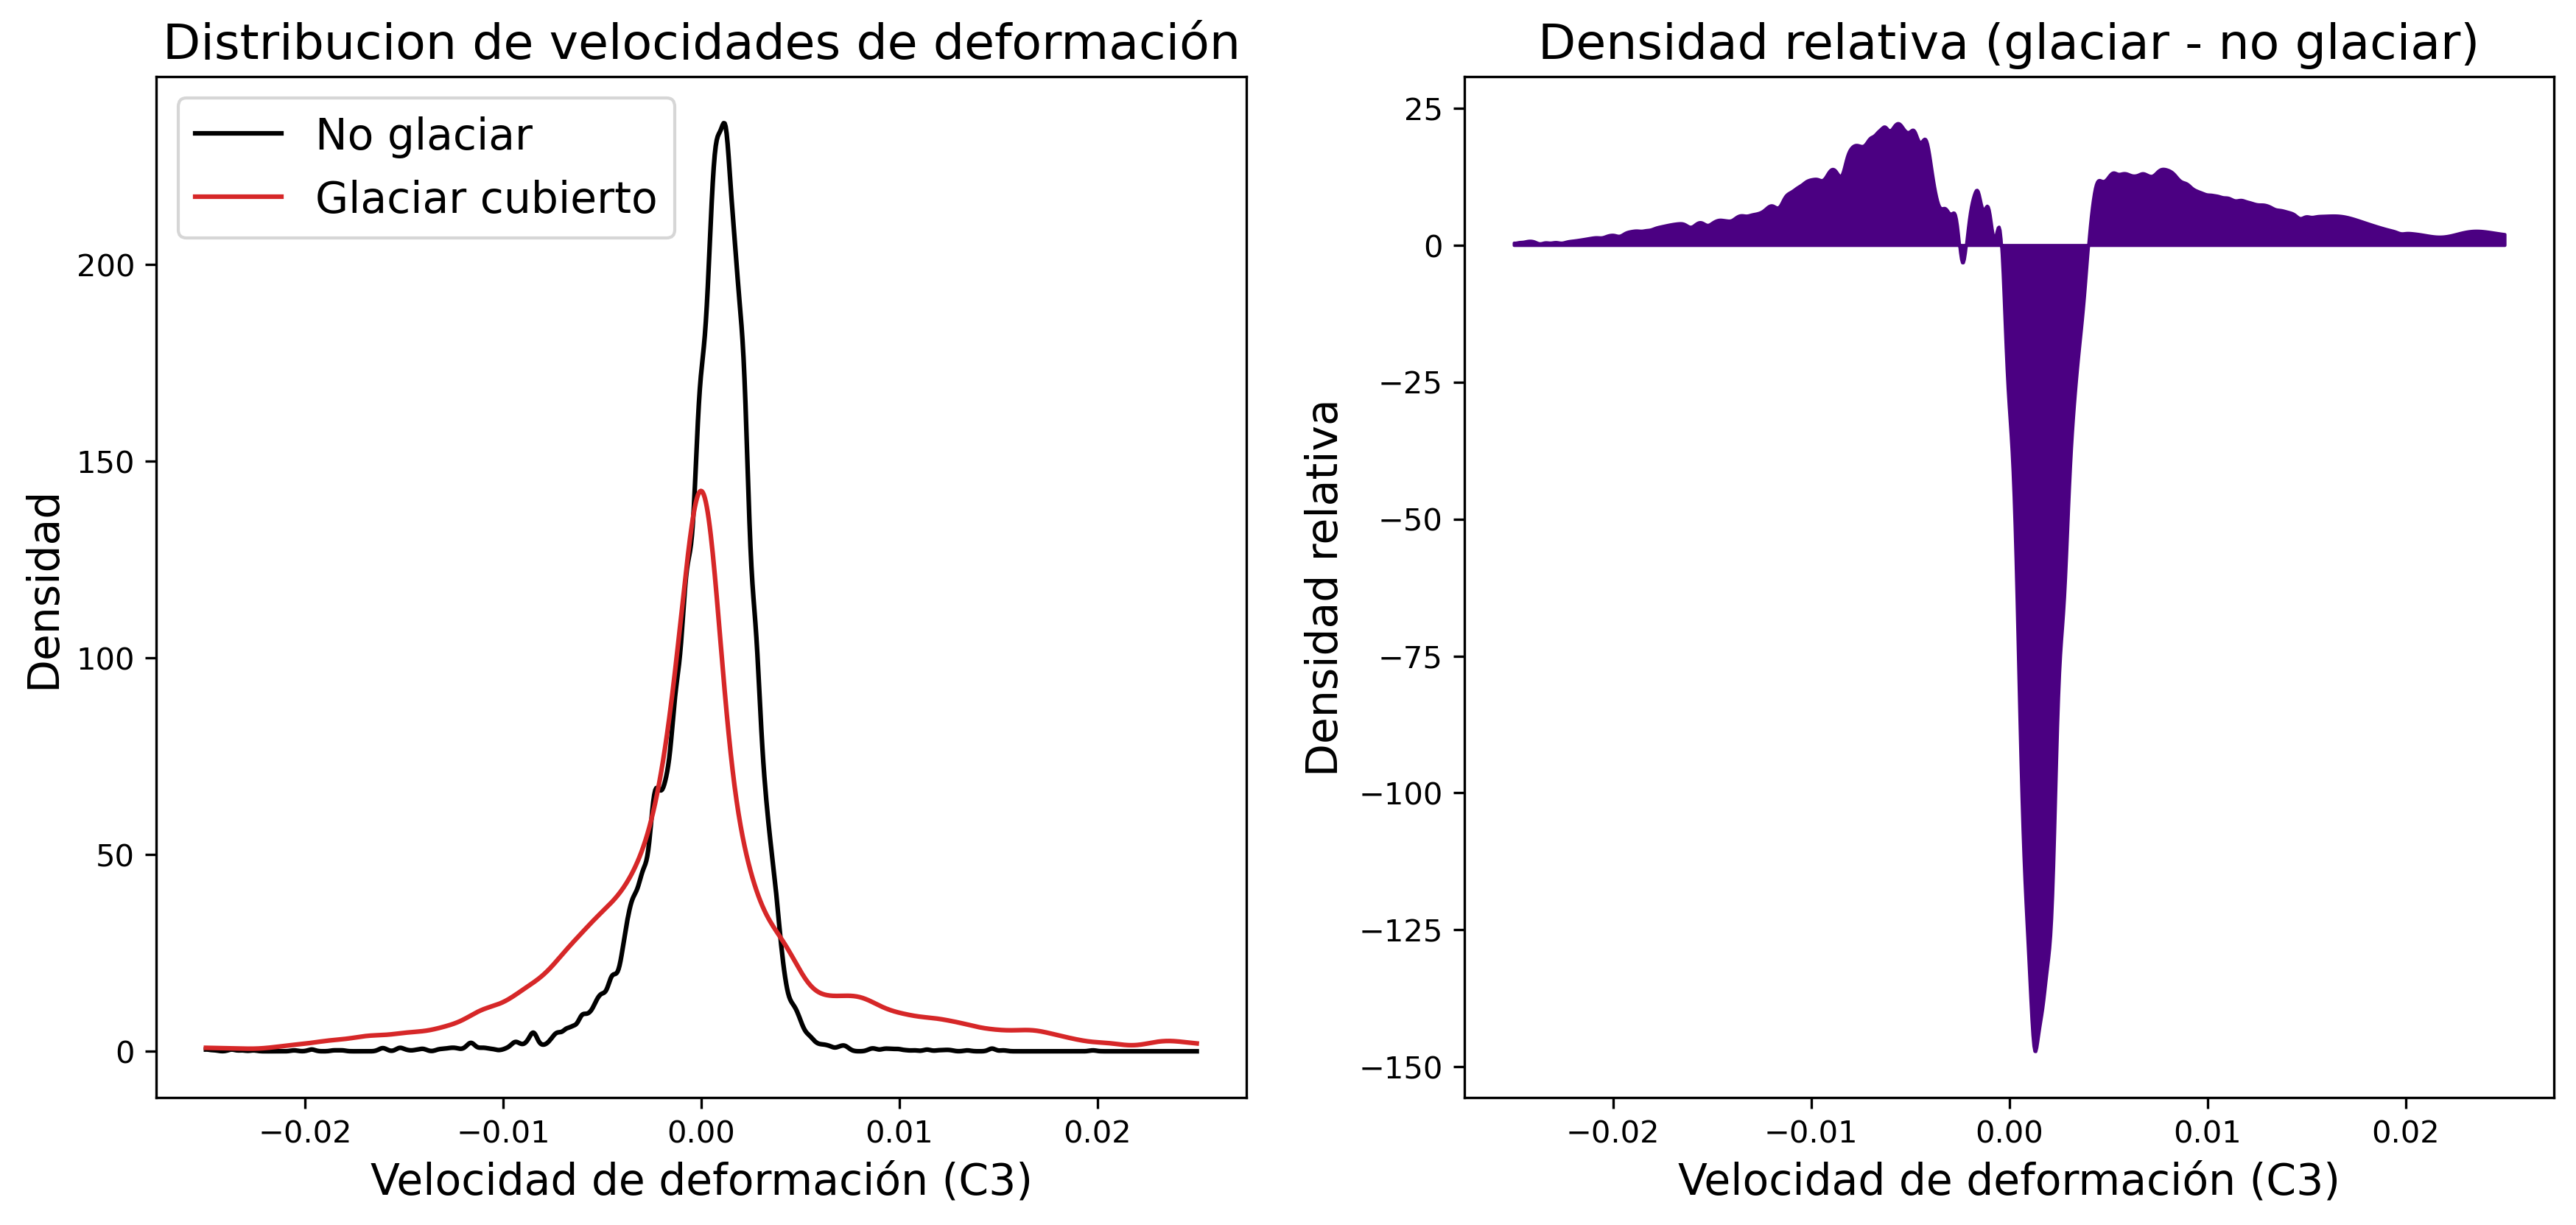

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
ax1, ax2 = axes
ax1.plot(X, vel_notgla, color="black", label="No glaciar")
ax1.plot(X, vel_gla, color="tab:red", label="Glaciar cubierto")
ax1.set_title("Distribucion de velocidades de deformación", size=16)
ax1.set_xlabel("Velocidad de deformación (C3)", size=14)
ax1.set_ylabel("Densidad", size=14)
ax1.legend(prop={"size":14})

ax2.fill_between(X, vel_gla-vel_notgla, color="indigo")
ax2.set_title("Densidad relativa (glaciar - no glaciar)", size=16)
ax2.set_xlabel("Velocidad de deformación (C3)", size=14)
ax2.set_ylabel("Densidad relativa", size=14)

# Diferencia contigua

Se evaluúa la diferencia entre un pixel y los pixeles que lo rodean. Se hace un histograma para cada clase.

In [37]:
ks=1

vels_notgla = convolution_hist(c3, ks=ks, consider = sin_glaciares_c3)
vels_gla    = convolution_hist(c3, ks=ks, consider = en_glaciares_c3)

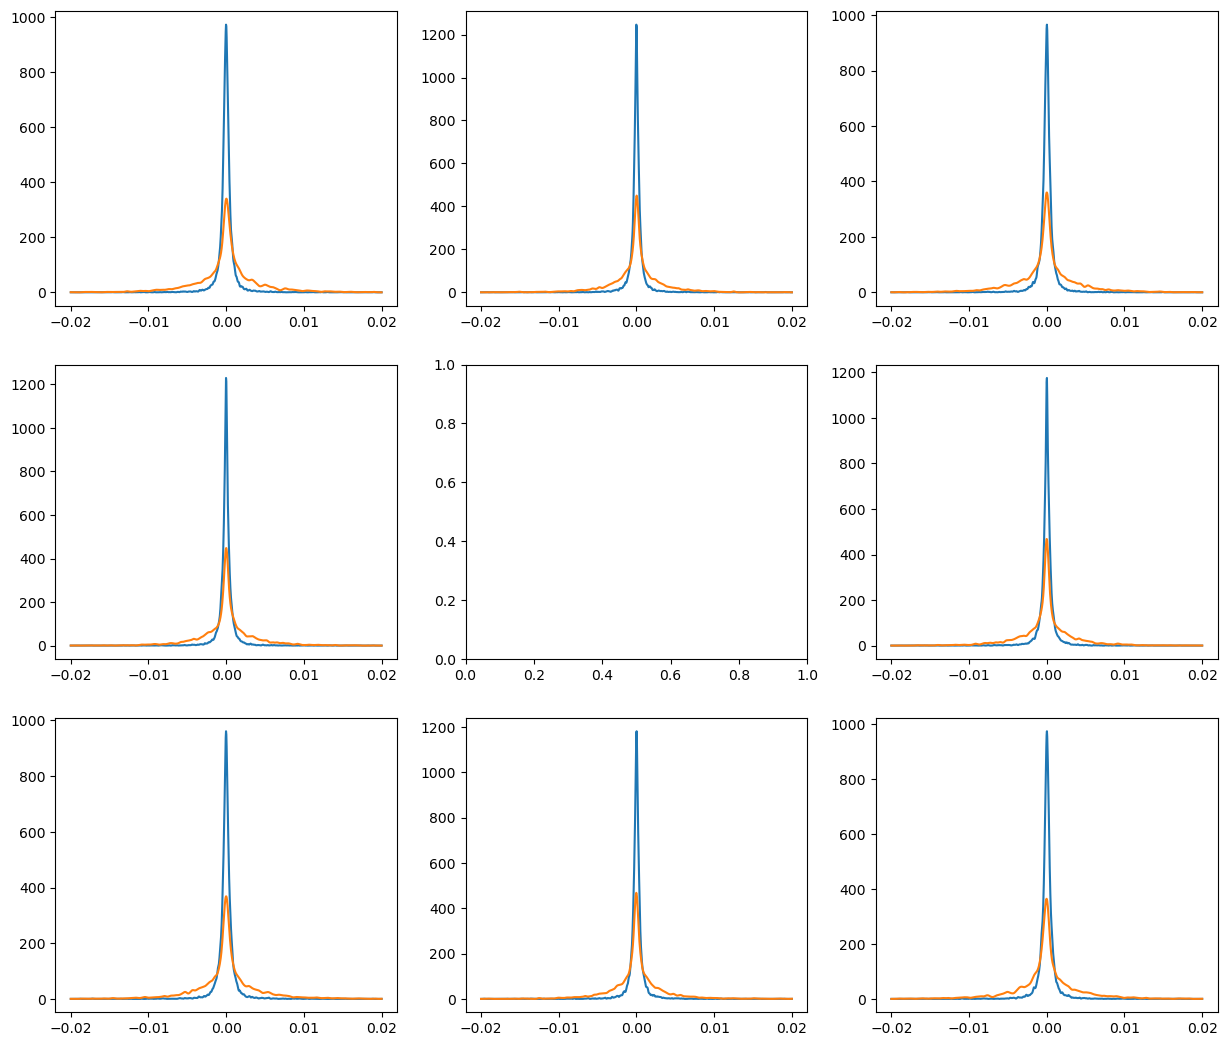

In [38]:
X = np.linspace(-.02, .02, 1000)

fig, axes = plt.subplots(3, 3, figsize = (15, 13))

for i in range(3):
    for j in range(3):
        if (i,j) != (1,1):
            axes[i,j].plot(X, density(X, vels_notgla[3*i+j], sigma_scale=.05))
            axes[i,j].plot(X, density(X, vels_gla[3*i+j], sigma_scale=.05))

Restamos ambos histogramas.

In [39]:
X = np.linspace(-.01, .01, 1000)
vels_hist = [density(X, vels_g, sigma_scale=.05)-density(X, vels_ng, sigma_scale=.05)
            for vels_g, vels_ng in zip (vels_gla, vels_notgla)]

C:\Users\Diego\AppData\Local\Temp\ipykernel_23504\2424067158.py:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.exp(-(X - data.reshape(-1, 1))**2 /(2*sigma**2))/(sigma*np.sqrt(2*np.pi)), axis=0)
C:\Users\Diego\AppData\Local\Temp\ipykernel_23504\2424067158.py:4: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.exp(-(X - data.reshape(-1, 1))**2 /(2*sigma**2))/(sigma*np.sqrt(2*np.pi)), axis=0)


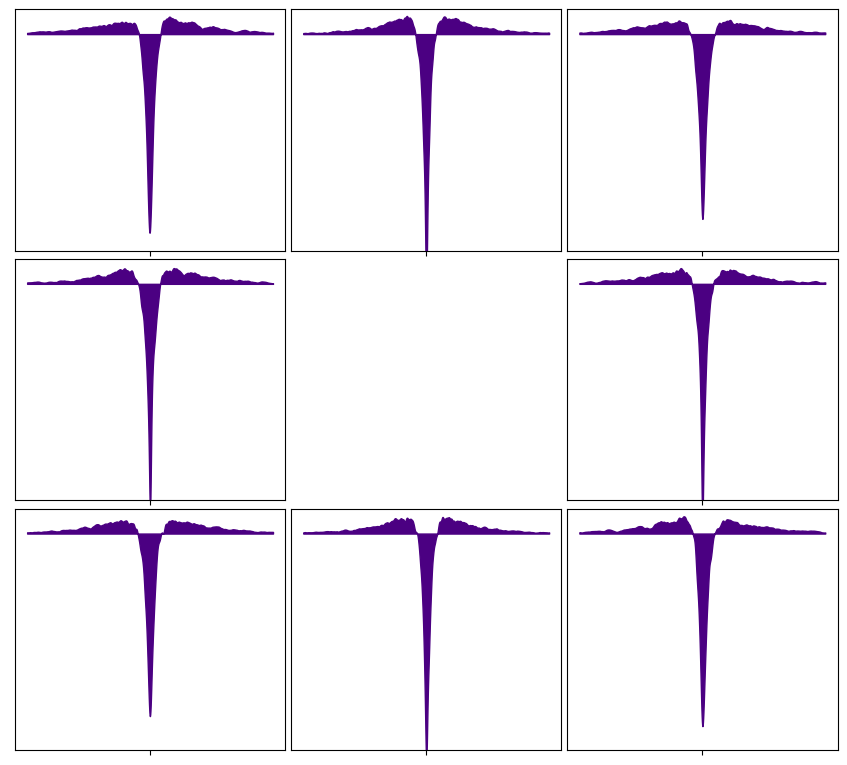

In [40]:
fig, axes = plt.subplots(3, 3, figsize = (9, 8))

plt.tight_layout(h_pad=-1.5, w_pad=-3)

for i in range(3):
    for j, ax in enumerate(axes[i]):
        if [i,j] is not [1,1]:
            ax.fill_between(X, vels_hist[3*i+j], color="indigo")
            ax.set_xticks([0])
            ax.set_xticklabels([""])
            ax.set_yticks([])
            ax.set_ylim((-700,80))
axes[1, 1].axis("off")
plt.show()

Realizamos average pooling para realizar este gráfico mirando a más distancia. Repetimos visualización

In [42]:
c3_l2 = avg_pool(c3)
c3_l3 = avg_pool(c3_l2)
engla_l2 = avg_pool(en_glaciares_c3)
engla_l3 = avg_pool(engla_l2)
nogla_l2 = avg_pool(sin_glaciares_c3)
nogla_l3 = avg_pool(nogla_l2)

vels_notgla = convolution_hist(c3_l2, consider = nogla_l2)
vels_gla    = convolution_hist(c3_l2, consider = engla_l2)

In [43]:
X = np.linspace(-.01, .01, 1000)
vels_hist = [density(X, vels_g, sigma_scale=.05)-density(X, vels_ng, sigma_scale=.05)
            for vels_g, vels_ng in zip (vels_gla, vels_notgla)]

C:\Users\Diego\AppData\Local\Temp\ipykernel_23504\2424067158.py:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.exp(-(X - data.reshape(-1, 1))**2 /(2*sigma**2))/(sigma*np.sqrt(2*np.pi)), axis=0)
C:\Users\Diego\AppData\Local\Temp\ipykernel_23504\2424067158.py:4: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.exp(-(X - data.reshape(-1, 1))**2 /(2*sigma**2))/(sigma*np.sqrt(2*np.pi)), axis=0)


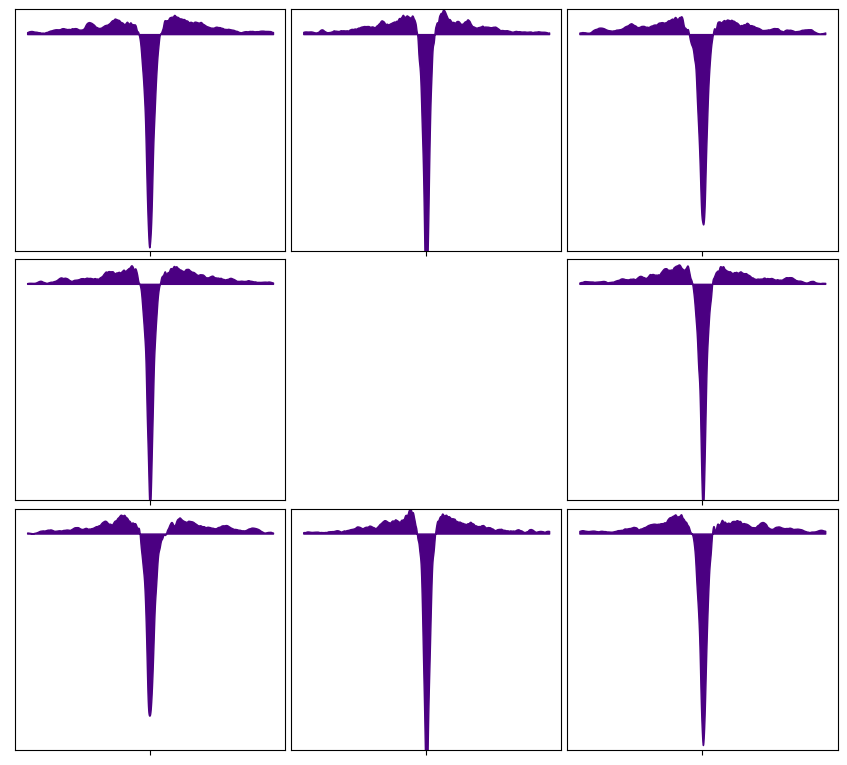

In [44]:
fig, axes = plt.subplots(3, 3, figsize = (9, 8))

plt.tight_layout(h_pad=-1.5, w_pad=-3)

for i in range(3):
    for j, ax in enumerate(axes[i]):
        if [i,j] is not [1,1]:
            ax.fill_between(X, vels_hist[3*i+j], color="indigo")
            ax.set_xticks([0])
            ax.set_xticklabels([""])
            ax.set_yticks([])
            ax.set_ylim((-700,80))
axes[1, 1].axis("off")
plt.show()

Repetimos el análisis pero lo visualizamos de forma circular.

In [272]:
circular_gla = circular_hist(vels_gla, rang=.015, sigma_scale=.15)

In [285]:
circular_notgla = circular_hist(vels_notgla, rang=.015, sigma_scale=.15)

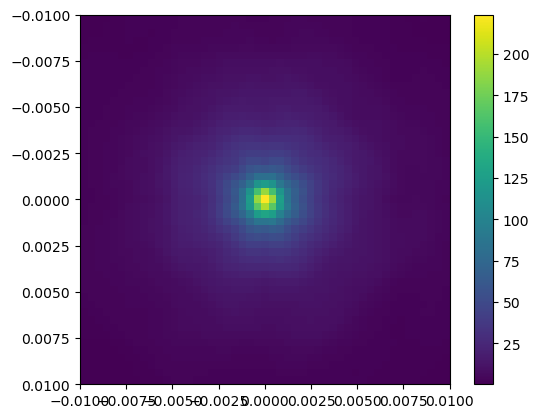

In [287]:
plt.imshow(circular_gla, cmap="viridis", extent=[-.01, .01, .01, -.01])
plt.colorbar()

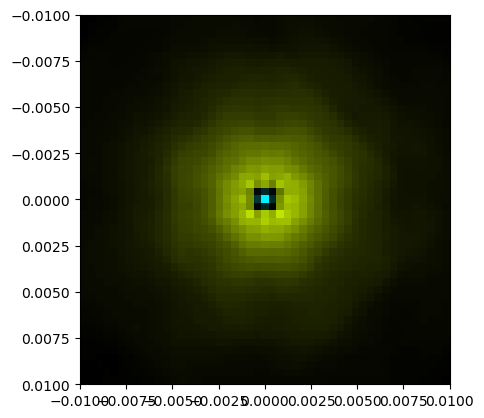

In [292]:
circular_rel = circular_gla-circular_notgla
circular_rel = np.where(circular_rel>0, circular_rel/np.max(circular_rel), -circular_rel/np.min(circular_rel))
plt.imshow(circular_rel, cmap=fluor, extent=[-.01, .01, .01, -.01])